The goal being to study backports in an ecosystem, we will focus on:

 - Packages being required by other packages (otherwise, there is no need to backport updates!);
 - Packages being sufficiently required by other packages (see above);
 - Required packages being active (abandonned packages are unlikely to deploy backports);
 - Dependent packages being active (one can expect packages abandonned for years to still rely on very old versions of their dependencies)
 
This notebook aims to select required and dependent packages based on some thresholds.

In [1]:
import pandas
import matplotlib
import seaborn
import tqdm

from version import Version
from parsers import parse_or_empty
from parsers import NPMParser

%matplotlib inline

In [2]:
FIG_SIZE = (6, 4)
PALETTE = seaborn.color_palette()

In [3]:
df_releases = (
    pandas.read_csv('../data-raw/releases.csv.gz')
    .assign(date=lambda d: pandas.to_datetime(d['date'], infer_datetime_format=True))
    .dropna()
)

In [4]:
df_dependencies = (
    pandas.read_csv('../data-raw/dependencies.csv.gz')
    .dropna()
)

Let's have a quick look at the data:

In [5]:
df_releases

,package,version,date
0,0,0.0.0,2014-04-01 22:51:11
1,001,0.0.1,2014-08-08 06:02:45
2,001_skt,0.0.1,2014-08-08 06:09:50
3,001_test,0.0.1,2014-08-08 06:36:13
4,007,0.0.0,2013-07-26 19:46:10
...,...,...,...
6773905,es-date,1.0.0,2018-12-22 20:55:02
6773906,gl-aabb3,1.0.0,2018-12-22 20:56:45
6773907,morphjam,1.0.0,2018-12-22 20:58:54
6773908,react-github-calendar-x,1.0.0,2018-12-22 21:08:20


In [6]:
df_dependencies

,source,version,target,constraint
0,01,0.0.1,commander,1.0.x
1,0815,0.1.0,commander,>= 1.1.1
2,0815,0.1.0,glob,>= 3.1.17
3,0815,0.1.0,async,>= 0.1.22
4,0815,0.1.0,wrench,>= 1.4.4
...,...,...,...,...
33224897,react-github-calendar-x,1.0.0,github-calendar-parser,^1.1.9
33224898,react-github-calendar-x,1.0.0,formatoid,^1.2.2
33224899,react-github-calendar-x,1.0.0,elly,^1.1.9
33224900,react-github-calendar-x,1.0.0,add-subtract-date,^1.0.13


We convert versions to semver syntax, and remove those that cannot be converted.

In [7]:
df_releases[['major', 'minor', 'patch', 'misc']] = (
    df_releases['version'].str.extract(Version.RE, expand=True)
)
df_releases[['major', 'minor', 'patch']] = df_releases[['major', 'minor', 'patch']].astype(float)

# Remove non-compliant versions
n = len(df_releases)
df_releases = df_releases.dropna(subset=['major', 'minor', 'patch'])
print(n - len(df_releases), 'non-compliant versions dropped (total was {})'.format(n))

# Remove prereleases and duplicates, keep first
n = len(df_releases)
df_releases = (
    df_releases
    [lambda d: d['misc'].isnull()]
    .sort_values(['package', 'date'])
    .drop_duplicates(['package', 'major', 'minor', 'patch'], keep='last')
    .drop(columns=['misc'])
)
print(n - len(df_releases), 'prerelease and duplicated versions dropped (total was {})'.format(n))

0 non-compliant versions dropped (total was 6773833)
745902 prerelease and duplicated versions dropped (total was 6773833)


To select a set of required and dependent packages, we remove packages that were not active for some time.

In [8]:
LAST_ACTIVITY = df_releases.date.max() - pandas.to_timedelta('365 days')
LAST_ACTIVITY

Timestamp('2017-12-22 21:12:35')

In [9]:
print('Packages and releases:', len(df_releases.drop_duplicates('package')), len(df_releases))
print('Active packages:', len(df_releases[lambda d: d['date'] >= LAST_ACTIVITY].drop_duplicates('package')))

Packages and releases: 902455 6027931
Active packages: 325502


Then we consider only dependencies from the latest version of each package. This will allow us to quantify the number of dependents for each required packages. 

In [10]:
df_dependencies = (
    df_dependencies
    .merge(
        (
            df_releases
            [['package', 'version', 'date']]
            [lambda d: d['date'] >= LAST_ACTIVITY]
            .sort_values('date')
            .drop_duplicates('package', keep='last')
        ),
        how='inner',
        left_on=['source', 'version'],
        right_on=['package', 'version']
    )
    .drop(columns=['package'])
)

In [11]:
df_dependencies

,source,version,target,constraint,date
0,101,1.6.3,clone,^1.0.2,2018-04-15 19:05:46
1,101,1.6.3,deep-eql,^0.1.3,2018-04-15 19:05:46
2,101,1.6.3,keypather,^1.10.2,2018-04-15 19:05:46
3,2,2.0.0,add-counter,^1.0.0,2018-08-22 15:36:49
4,2,2.0.0,is-instance-of,^1.0.1,2018-08-22 15:36:49
...,...,...,...,...,...
938567,react-github-calendar-x,1.0.0,github-calendar-parser,^1.1.9,2018-12-22 21:08:20
938568,react-github-calendar-x,1.0.0,formatoid,^1.2.2,2018-12-22 21:08:20
938569,react-github-calendar-x,1.0.0,elly,^1.1.9,2018-12-22 21:08:20
938570,react-github-calendar-x,1.0.0,add-subtract-date,^1.0.13,2018-12-22 21:08:20


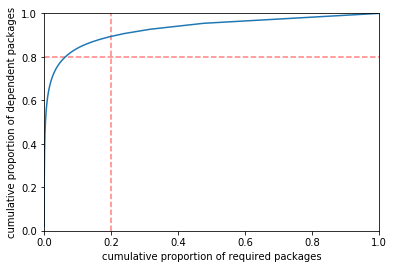

In [12]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(FIG_SIZE)

data = (
    df_dependencies
    .groupby(['target'], sort=False)
    .agg({'source': 'count'})
    .sort_values('source', ascending=False)
    .assign(cum_source=lambda d: d['source'].cumsum())
    .assign(cum_target=lambda d: d.assign(n=1).n.cumsum())
    # Make them proportional
    .assign(
        cum_source=lambda d: d['cum_source'] / d['cum_source'].iloc[-1],
        cum_target=lambda d: d['cum_target'] / d['cum_target'].iloc[-1],
    )
)

data.set_index('cum_target')[['cum_source']].plot(ax=ax)

ax.legend().remove()
ax.set(
    xlabel='cumulative proportion of required packages',
    xlim=(0, 1),
    ylabel='cumulative proportion of dependent packages',
    ylim=(0, 1),
)

ax.hlines(0.8, 0, 1, color='r', alpha=0.5, linestyles='dashed')
ax.vlines(0.2, 0, 1, color='r', alpha=0.5, linestyles='dashed')

We must decide on how to select packages that will be kept as "required". 

In [13]:
data.query('cum_source >= 0.8').iloc[0]

source        16.000000
cum_source     0.800000
cum_target     0.063551
Name: collect-stream, dtype: float64

In [14]:
data.query('cum_target >= 0.2').iloc[0]

source        4.000000
cum_source    0.893924
cum_target    0.200007
Name: react-native-code-push, dtype: float64

In [15]:
data.query('cum_target >= 0.1').iloc[0]

source        10.000000
cum_source     0.839936
cum_target     0.100010
Name: react-viewer, dtype: float64

In [16]:
data.query('source <= 20').iloc[0]

source        20.000000
cum_source     0.781901
cum_target     0.052194
Name: gherkin, dtype: float64

Keeping 10% of all required packages means we have at least 10 dependent packages. Keeping 20 dependent packages implies ignoring nearly 95% of all required packages. 

In [17]:
MIN_REQ = 20

Now we retrieve the list of these required packages, and we identify for all their releases their order and type.
This will be our dataset of "required packages". Based on these packages, we will then create a dataset of "dependent packages".

In [18]:
required = data[lambda d: d['source'] >= MIN_REQ].index

In [19]:
data = []
for name, group in tqdm.tqdm(df_releases[lambda d: d['package'].isin(required)].groupby('package', sort=False)):
    group = (
        group
        # Rank by version
        .sort_values(['major', 'minor', 'patch'])
        .assign(
            rank=lambda d: d.assign(N=1).N.cumsum(),
            kinitial=lambda d: d['major'].shift(1).isnull(),
            kmajor=lambda d: (d['major'] - d['major'].shift(1)).clip(0, 1).astype(bool),
            kminor=lambda d: (d['minor'] - d['minor'].shift(1)).clip(0, 1).astype(bool),
            kpatch=lambda d: (d['patch'] - d['patch'].shift(1)).clip(0, 1).astype(bool),
        )
        .assign(kind=lambda d: d[['kinitial', 'kmajor', 'kminor', 'kpatch']].idxmax(axis=1))
        .replace({'kind': {'kinitial': 'initial', 'kmajor': 'major', 'kminor': 'minor', 'kpatch': 'patch'}})        
        .drop(columns=['kinitial', 'kmajor', 'kminor', 'kpatch'])
        
        # Rank by date
        .sort_values(['date', 'rank'])  # Use rank if versions are distributed on the same day (e.g. imports)
        .assign(rank_date=lambda d: d.assign(N=1).N.cumsum())
        # Detect backported releases
        .assign(hrank=lambda d: d['rank'].expanding().max())
        # Identify backported releases. The value corresponds to the highest rank seen so far...
        .assign(backported=lambda d: d['hrank'].where(d['rank'] < d['hrank'], pandas.np.nan))
        .drop(columns=['hrank'])
        # ... but it could be the case that the backport is released before its "origin", so we check
        # the date of rank + 1 as well, and take the closest date.
        .pipe(lambda df: 
            df.merge(
                df[['date', 'rank']], 
                how='left', 
                left_on=['backported'], 
                right_on=['rank'],
                suffixes=('', '_previous'),
            )
            .merge(
                df[['date', 'rank']].assign(rank=lambda d: d['rank'] - 1),
                how='left',
                left_on=['backported'],
                right_on=['rank'],
                suffixes=('', '_next'),
            )
            .assign(rank_next=lambda d: d['rank_next'] + 1)
            # Take closest date
            .assign(backported_from=lambda d:
                d['rank_previous'].where(abs(d['date'] - d['date_previous']) <= abs(d['date'] - d['date_next']), d['rank_next'])
            )
        )
        .drop(columns=['date_previous', 'date_next', 'rank_previous', 'rank_next'])
        .assign(backported=lambda d: ~d['backported'].isnull())
    )
    
    data.append(group)
    
df_required = (
    pandas.concat(data)
    .sort_values(['package', 'rank'])
    [['package', 'version', 'major', 'minor', 'patch', 'rank', 'date', 'rank_date', 'backported', 'backported_from']]
)

100%|██████████| 4451/4451 [03:03<00:00, 24.21it/s]


Let's have a look at the data.

In [20]:
df_required.query('package == "vue-awesome"').iloc[25:35]

,package,version,major,minor,patch,rank,date,rank_date,backported,backported_from
25,vue-awesome,2.3.5,2.0,3.0,5.0,26,2018-03-01 15:51:36,26,False,NaN
28,vue-awesome,2.3.6,2.0,3.0,6.0,27,2018-06-03 03:51:19,29,True,31.0
30,vue-awesome,2.3.7,2.0,3.0,7.0,28,2018-06-03 10:07:02,31,True,32.0
34,vue-awesome,2.3.8,2.0,3.0,8.0,29,2018-07-09 07:15:18,35,True,35.0
26,vue-awesome,3.0.0,3.0,0.0,0.0,30,2018-04-02 06:56:11,27,False,NaN
27,vue-awesome,3.0.1,3.0,0.0,1.0,31,2018-06-03 03:39:54,28,False,NaN
29,vue-awesome,3.0.2,3.0,0.0,2.0,32,2018-06-03 10:05:28,30,False,NaN
31,vue-awesome,3.0.3,3.0,0.0,3.0,33,2018-06-27 04:02:24,32,False,NaN
32,vue-awesome,3.0.4,3.0,0.0,4.0,34,2018-07-09 04:05:08,33,False,NaN
33,vue-awesome,3.0.5,3.0,0.0,5.0,35,2018-07-09 07:05:47,34,False,NaN


In [21]:
# Save data
df_required.to_csv('../data/required.csv.gz', index=False, compression='gzip')

Now let's collect data for dependent packages. We'll convert dependency constraint to intervals, and then we look at what is the latest and highest versions being accepted by that constraint. 

In [54]:
df_dependents = (
    df_dependencies
    [lambda d: d['target'].isin(required)]
)

intervals = dict() 
parser = NPMParser()

for constraint in tqdm.tqdm(df_dependents.constraint.drop_duplicates()):
    interval = parse_or_empty(parser, constraint)
    d = {'interval': interval}
    
    if interval.is_empty():
        d['empty'] = True
        d['major'] = d['minor'] = d['patch'] = d['dev'] = False
    else:
        base = interval.lower 
        d['empty'] = False
        d['major'] = Version(float('inf'), 0, 0) in interval
        d['minor'] = Version(base.major, float('inf'), 0) in interval
        d['patch'] = Version(base.major, base.minor, float('inf')) in interval
        d['dev'] = Version(1, 0, 0) > interval
        
    intervals[constraint] = d
    
# Are all intervals equal to their enclosure? (i.e. are there "gaps"?)
len([i['interval'] for i in intervals.values() if i['interval'] != i['interval'].enclosure()])

100%|██████████| 12362/12362 [00:20<00:00, 593.96it/s]


55

In [55]:
# Identify highest accepted releases
data = []

for target, group in tqdm.tqdm(df_dependents.groupby('target', as_index=False, sort=False)):
    releases = (
        df_required[lambda d: d['package'] == target]
        .assign(version=lambda d: d['version'].apply(lambda v: Version(v)))
        .sort_values('rank', ascending=False)
    )
    
    for constraint, group in group.groupby('constraint', as_index=False, sort=False):
        d = intervals[constraint]
        interval = d['interval']
        selected = None
        
        for release in releases.itertuples():
            if release.version in interval:
                selected = release.rank
                break  # Because they are sorted by descending rank
        else:
            selected = pandas.np.nan
            
        data.append((
            group.assign(
                interval=str(interval),
                selected=selected,
                c_empty=d['empty'],
                c_dev=d['dev'],
                c_major=d['major'],
                c_minor=d['minor'],
                c_patch=d['patch'],
            )
        ))
        
df_dependents = (
    pandas.concat(data)
    .sort_values(['source', 'target'])
    [['source', 'version', 'date', 'target', 'constraint', 'interval', 'selected', 'c_empty', 'c_dev', 'c_major', 'c_minor', 'c_patch']]
)

100%|██████████| 4465/4465 [06:12<00:00, 12.00it/s]


In [59]:
df_dependents

,source,version,date,target,constraint,interval,selected,c_empty,c_dev,c_major,c_minor,c_patch
906319,0-1-project,0.0.1,2018-12-10 06:44:08,chai,^4.2.0,"[4.2.0,5.0.0)",71.0,False,False,False,True,True
906318,0-1-project,0.0.1,2018-12-10 06:44:08,vue,^2.5.17,"[2.5.17,3.0.0)",144.0,False,False,False,True,True
906317,0-1-project,0.0.1,2018-12-10 06:44:08,vue-hot-reload-api,^2.3.1,"[2.3.1,3.0.0)",30.0,False,False,False,True,True
906316,0-1-project,0.0.1,2018-12-10 06:44:08,vue-template-compiler,^2.5.17,"[2.5.17,3.0.0)",60.0,False,False,False,True,True
618596,00.demo,1.0.0,2018-08-11 02:15:29,chalk,^2.1.0,"[2.1.0,3.0.0)",23.0,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
617457,zzzd,1.0.0,2018-08-10 08:32:47,vuedraggable,^2.16.0,"[2.16.0,3.0.0)",25.0,False,False,False,True,True
617458,zzzd,1.0.0,2018-08-10 08:32:47,vuex,^3.0.1,"[3.0.1,4.0.0)",32.0,False,False,False,True,True
555979,zzzzhy,1.0.4,2018-07-09 09:16:20,react,^16.4.0,"[16.4.0,17.0.0)",84.0,False,False,False,True,True
555981,zzzzhy,1.0.4,2018-07-09 09:16:20,react-dom,^16.4.0,"[16.4.0,17.0.0)",52.0,False,False,False,True,True


In [57]:
df_dependents.to_csv('../data/dependents.csv.gz', index=False, compression='gzip')